In [1]:
import collections
import math
import os
import random
import zipfile
import numpy as np
import urllib
import tensorflow as tf

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Word2vec model

## cannot download

In [8]:
url = 'http://mattmahoney.net/dc/'
def maybe_download(filename, expected_bytes):
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    print(statinfo)
    if statinfo.st_size == expected_bytes:
        print("Found and verified", filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename
filename = maybe_download('text8.zip', 31344016)

os.stat_result(st_mode=33188, st_ino=8593844934, st_dev=16777220, st_nlink=1, st_uid=501, st_gid=20, st_size=278888, st_atime=1526306298, st_mtime=1526306293, st_ctime=1526306293)
Found and verified text8.zip


In [2]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
words = read_data('./text8.zip')
print("Data size", len(words))

Data size 17005207


In [3]:
vocabulary_size = 50000
def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size -1))
    dictionary = dict()
    for word, _ in count:
        # 單字編號
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

# data: tokenize raw data
# count: word frequency(top 50000)
# dictionary: word and token map
# reverse_dictionary: reversed dictionary
data, count, dictionary, reverse_dictionary = build_dataset(words)

In [4]:
del words
print('Most common words +(UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words +(UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [5]:
data_index = 0
# batch_size = 一個批次的sample個數
# num_skips = 從鄰居中選幾個樣本
# skip_window = 幾個鄰居
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape = (batch_size), dtype = np.int32)
    labels = np.ndarray(shape = (batch_size, 1), dtype = np.int32)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen = span)
    # 從頭(data_index = 0)開始把單字一個一個塞進buffer內
    # 這個迴圈只跑一次，因為之後每從右邊加單字，左邊會自動被擠掉，維持max_len = span
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # print(buffer)
    # 每跑一圈就完成 num_skips 個樣本，共要跑 batch_size//num_skips 圈
    for i in range(batch_size // num_skips):
        target = skip_window
        # 第skip_window個單字是目標，要找的是他的鄰居而不是他自己，所以加入targets_to_avoid
        # targets_to_avoid 是在buffer裏被禁用的單字index
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                # 個人註記：其實可以不用亂數產生，因為已經限制batch_size是num_skips的整數倍，所以每個單字都會找滿所有鄰居
                # 照順序加入後在打亂順序應該也可以，不需要亂數一直while loop
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            # labels是2維陣列，所以多一個0
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [6]:
batch, labels = generate_batch(8, 2, 1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], 
          '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3081 originated -> 12 as
3081 originated -> 5234 anarchism
12 as -> 6 a
12 as -> 3081 originated
6 a -> 12 as
6 a -> 195 term
195 term -> 2 of
195 term -> 6 a


In [9]:
batch_size = 128
embedding_size = 128    # 可以視為encoded後的向量維度
skip_window = 1
num_skips = 2

valid_size = 16
valid_window = 100      # top 100 的高頻單字
valid_example = np.random.choice(valid_window, valid_size, replace=True)
num_sampled = 64


In [10]:
graph = tf.Graph()
with graph.as_default():
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_label = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_example, dtype=tf.int32)
    
    with tf.device('/cpu:0'):
        # tf 矩陣維度要倒過來看(行，列)
        # embeddings 是一個128 * 50000 的矩陣
        # inputs 是一個50000的向量
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        # inputs is sparse vecter, all we need to find is which column value is 1 -> embed
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
        
        nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                        biases=nce_biases,
                                        labels = train_label,
                                        inputs = embed,
                                        num_sampled = num_sampled,
                                        num_classes = vocabulary_size))
    optimizier = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
    
    init = tf.global_variables_initializer()

In [11]:
num_step = 100001

with tf.Session(graph=graph) as session:
    init.run()
    print("Initialized")
    
    average_loss = 0
    for step in range(num_step):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_label: batch_labels}
        _, loss_val = session.run([optimizier, loss], feed_dict = feed_dict)
        average_loss += loss_val
        if step % 2000 ==0:
            if step > 0:
                average_loss/=2000
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_example[i]]
                top_k = 8
                nearest = (-sim[i, :]).argsort()[1: top_k +1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," %(log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  262.0520324707031
Nearest to years: drowned, alberts, belmont, may, transitory, chojn, prosecutors, olympus,
Nearest to one: davidson, bonzo, psychomotor, hansa, mel, re, allergies, cleveland,
Nearest to however: dimensionally, protists, cathal, vcr, adenauer, evasive, memorized, consistency,
Nearest to other: sect, stilgar, rei, burrell, spotted, sld, shimei, restores,
Nearest to than: shaka, corbusier, schodt, bulgars, servo, reigned, closures, lumley,
Nearest to i: negroes, glutamic, cantonal, castrato, cooperation, bicarbonate, azrael, statics,
Nearest to see: encarta, clyde, castes, venous, procreation, windows, tocharians, indifference,
Nearest to i: negroes, glutamic, cantonal, castrato, cooperation, bicarbonate, azrael, statics,
Nearest to not: icann, flattened, mujahedin, georgia, randomization, zanu, ancona, moro,
Nearest to have: mathematical, osteoporosis, thicker, granite, kenji, shirt, auxiliary, fpga,
Nearest to can: portrayal, free

Average loss at step  52000 :  5.174292196035385
Average loss at step  54000 :  5.1036260980367665
Average loss at step  56000 :  5.039735710978508
Average loss at step  58000 :  5.0908731696605685
Average loss at step  60000 :  4.945095277249813
Nearest to years: paparazzi, five, belmont, drowned, six, barren, alberts, gesch,
Nearest to one: two, four, six, seven, five, three, eight, michelob,
Nearest to however: but, and, which, microcebus, tamarin, thibetanus, that, aba,
Nearest to other: mast, depression, some, spd, operatorname, restores, breaking, fawcett,
Nearest to than: or, brett, and, reigned, microcebus, abitibi, bridgetown, vdash,
Nearest to i: checker, hogs, locust, gad, they, deployment, mono, cantonal,
Nearest to see: phi, renovate, inventive, castes, and, lysosomes, nguni, indifference,
Nearest to i: checker, hogs, locust, gad, they, deployment, mono, cantonal,
Nearest to not: cypress, akita, who, to, it, leontopithecus, michelob, they,
Nearest to have: has, had, are, w

In [12]:
import matplotlib.pyplot as plt

# low_dim_embs = n個2維坐標
def plot_with_labels(low_dim_embs, labels, filename = 'tsne.png'):
    assert low_dim_embs.shape[0]>=len(labels), "More labels than embeddings"
    plt.figure(figsize = (18, 18))
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext = (5,2), textcoords ='offset points', ha = 'right', va ='bottom')
    plt.savefig(filename)
    

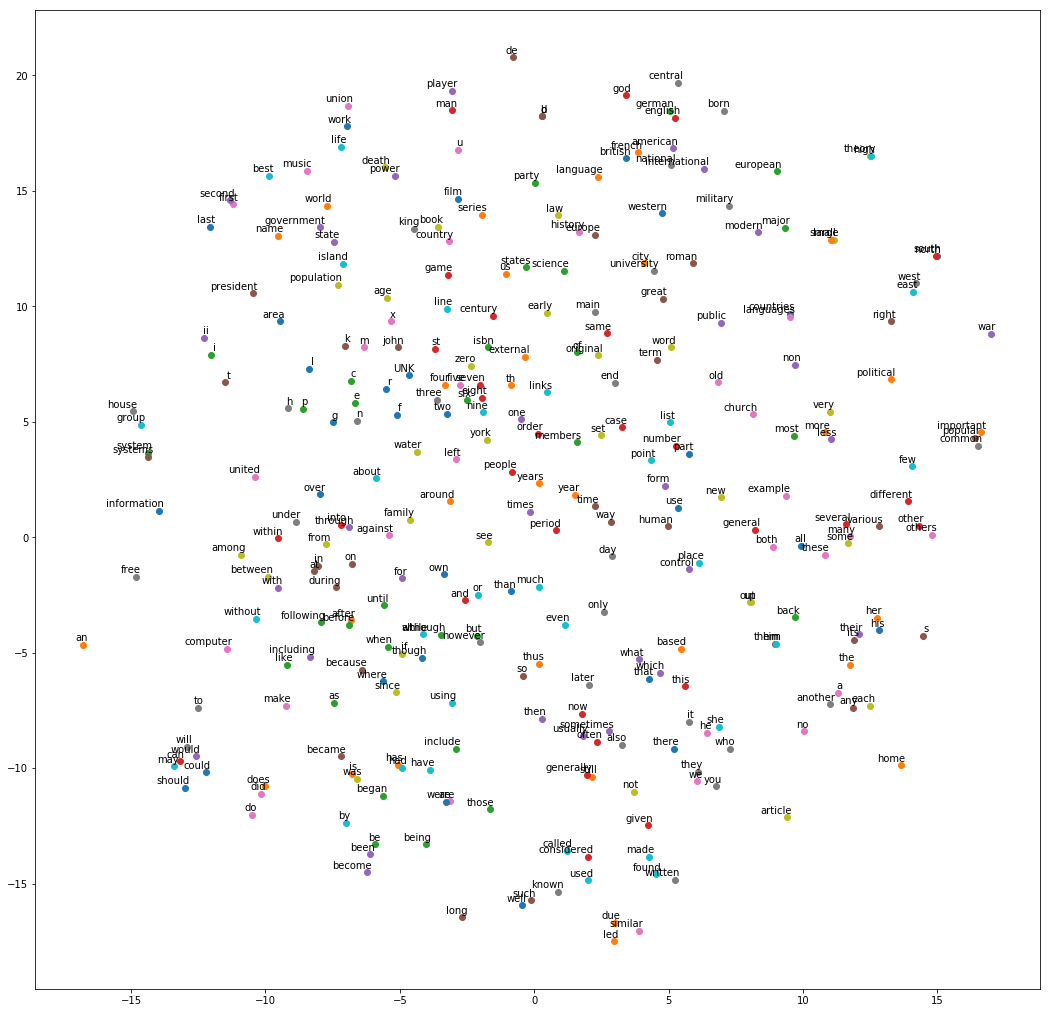

In [15]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 300
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

# LSTM model

In [17]:
import reader
import time
import numpy as np
import tensorflow as tf

In [18]:
class PTBInput(object):
    def __init__(self, config, data, name=None):
        # declare a and b as equal to c --> a=b=c
        self.batch_size = batch_size = config.batch_size
        self.num_steps = num_steps = config.num_steps
        self.epoch_size = ((len(data)//batch_size)-1)//num_step
        self.input_data, self.targets = reader.ptb_producer(data, batch_size, num_step, name)
        

In [24]:
class PTBModel(object):
    def __init__(self, is_training, config, input_):
        self._input = input_
        
        batch_size = input_.batch_size
        num_steps = input_.num_steps
        size = config.hidden_size
        vocab_size = config.vocab_size
        
        def lstm_cell():
            return tf.contrib.rnn.BasicLSTMCell(size, forget_bias=0.0, state_is_tuple=True)
        attn_cell = lstm_cell
        if is_training and config.keep_prob< 1:
            def attn_cell():
                return tf.contrib.rnn.DropoutWrapper(lstm_cell(), output_keep_prob=config.keep_prob)
        cell = tf.contrib.rnn.MultiRNNCell([attn_cell() for _ in range(config.num_layers)], state_is_tuple=True)
        self._initial_state = cell.zero_state(batch_size, tf.float32)
        
        with tf.device("/cpu:0"):
            embedding = tf.get_variable("embbedding", [vocab_size, size], dtype=tf.float32)
            inputs = tf.nn.embedding_lookup(embedding, input_.input_data)
        if is_training and config.keep_prob < 1:
            inputs = tf.nn.dropout(inputs, config.keep_prob)
        outputs = []
        state = self._initial_state
        with tf.variable_scope("RNN"):
            for time_step in range(num_steps):
                if time_step > 0: tf.get_variable_scope().reuse_variables()
                (cell_output, state) = cell(inputs[:, time_step, :], state)
                outputs.append(cell_output)

In [29]:
from keras.layers.core import Activation, Dense
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import collections
import nltk
import numpy as np

## EDA 
maxlen = 0
word_freqs = collections.Counter()
num_recs = 0
with open('./train.txt','r+') as f:
    for line in f:
        label, sentence = line.strip().split("\t")
        words = nltk.word_tokenize(sentence.lower())
        if len(words) > maxlen:
            maxlen = len(words)
        for word in words:
            word_freqs[word] += 1
        num_recs += 1
print('max_len ',maxlen)
print('nb_words ', len(word_freqs))

## 准备数据
MAX_FEATURES = 2000
MAX_SENTENCE_LENGTH = 40
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {x[0]: i+2 for i, x in enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0
word2index["UNK"] = 1
index2word = {v:k for k, v in word2index.items()}
X = np.empty(num_recs,dtype=list)
y = np.zeros(num_recs)
i=0
with open('./train.txt','r+') as f:
    for line in f:
        label, sentence = line.strip().split("\t")
        words = nltk.word_tokenize(sentence.lower())
        seqs = []
        for word in words:
            if word in word2index:
                seqs.append(word2index[word])
            else:
                seqs.append(word2index["UNK"])
        X[i] = seqs
        y[i] = int(label)
        i += 1
X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)
## 数据划分
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
## 网络构建
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE,input_length=MAX_SENTENCE_LENGTH))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))
model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])


max_len  42
nb_words  2328
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 128)           256256    
_________________________________________________________________
lstm_7 (LSTM)                (None, 40, 64)            49408     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 318,113
Trainable params: 318,113
Non-trainable params: 0
_________________________________________________________________


In [30]:
## 网络训练
model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,validation_data=(Xtest, ytest))
## 预测
score, acc = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)
print("\nTest score: %.3f, accuracy: %.3f" % (score, acc))
print('{}   {}      {}'.format('预测','真实','句子'))
for i in range(5):
    idx = np.random.randint(len(Xtest))
    xtest = Xtest[idx].reshape(1,40)
    ylabel = ytest[idx]
    ypred = model.predict(xtest)[0][0]
    sent = " ".join([index2word[x] for x in xtest[0] if x != 0])
    print(' {}      {}     {}'.format(int(round(ypred)), int(ylabel), sent))

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 14s 2ms/step - loss: 0.2219 - acc: 0.8977 - val_loss: 0.0738 - val_acc: 0.9767
Epoch 2/10
5668/5668 [==============================] - 13s 2ms/step - loss: 0.0210 - acc: 0.9940 - val_loss: 0.0502 - val_acc: 0.9887
Epoch 3/10
5668/5668 [==============================] - 13s 2ms/step - loss: 0.0049 - acc: 0.9984 - val_loss: 0.0645 - val_acc: 0.9859
Epoch 4/10
5668/5668 [==============================] - 13s 2ms/step - loss: 0.0058 - acc: 0.9984 - val_loss: 0.0535 - val_acc: 0.9859
Epoch 5/10
5668/5668 [==============================] - 13s 2ms/step - loss: 0.0067 - acc: 0.9988 - val_loss: 0.0603 - val_acc: 0.9859
Epoch 6/10
5668/5668 [==============================] - 13s 2ms/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0733 - val_acc: 0.9866
Epoch 7/10
5668/5668 [==============================] - 13s 2ms/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0764 - val_acc: 0.9859
Epoch 8